# Deconvolving the Mixing Matrix

The goal of this notebook is showcase different ways in which masking can be taken into account when performing 2-point statistics on partial sky maps.

We consider four different methods which we can classify along two axis:
- Is the effect forward modelled in the theory or removed in the data?
- Are we working in Fourier or real space?

The four methods are:
- **Forward method** (Fourier / Forward): In this method we multiply the theory full-sky $C_\ell$ by the mixing matrix.
- **Master method** (Fourier / Forward & Invert): In this method we first multiply the theory full-sky $C_\ell$ by the mixing matrix. Then, we bin the resulting $C_\ell$. Finally, we multiply by the binned inverse mixing matrix.
- **Direct inversion** (Fourier / Invert): In this method we multiply the data by the inverse mixing matrix and bin the resulting $C_\ell$.
- **Polspice**: (Real / Invert): In this method we transform the $C_\ell$ to real-space angular correlation functions and divide them by the mask angular correlation function. This step has to be done carefully to account for the mixing between E and B modes. Finally we transform back to $C_\ell$.


## Dependencies

In [1]:
import camb
import iolaus
import heracles
import numpy as np
import healpy as hp
import matplotlib as mpl
import matplotlib.pyplot as plt
from heracles.twopoint import mixing_matrices

## Make data

In [2]:
nside = 1024
lmax = 1000
bin_num = 15
l = np.arange(lmax+1)
l2 = np.arange(2*lmax+1)

In [3]:
_eu_data_maps = heracles.read_maps("./data/euclid_data_maps.fits")
#vis_maps = heracles.read_maps("./data/euclid_visibility.fits")
#jkmap = hp.read_map("./data/euclid_jkmap_njk_5.fits")
#]mask = np.copy(jkmap)
#mask[mask != 0] = (
#    mask[mask != 0] / mask[mask != 0]
#)

In [4]:
eu_data_maps = {}
eu_data_maps[('POS', 1)] = _eu_data_maps['P,1']
eu_data_maps[('SHE', 1)] = _eu_data_maps['G,1']

In [5]:
mask = iolaus.make_mask(nside, mode="patch")
mask_cls = iolaus.mask2cls(mask, nside, lmax)

In [6]:
z = np.linspace(0, 3, 300)
pars = iolaus.get_pars()
z, nz = iolaus.get_nz(z)
z, bz = iolaus.get_bz(z)
sources = iolaus.get_sources(z, nz, bz)
theory_cls = iolaus.get_theory_cls(l, pars, sources)

In [7]:
for key in list(theory_cls.keys()):
    print(key, theory_cls[key].shape)

('POS', 'POS', 1, 1) (1001,)
('POS', 'SHE', 1, 1) (2, 1001)
('SHE', 'SHE', 1, 1) (3, 1001)


In [8]:
theory_map = iolaus.theory2map(theory_cls, nside)
mask = iolaus.make_mask(nside, mode="patch")
data_map = iolaus.apply_mask(theory_map, mask)

In [9]:
print(list(data_map.keys()) == list(eu_data_maps.keys()))
print(data_map[('POS', 1)].shape == eu_data_maps[('POS', 1)].shape)
print(data_map[('SHE', 1)].shape == eu_data_maps[('SHE', 1)].shape)

True
True
True


In [10]:
data_map[('SHE', 1)] = eu_data_maps[('SHE', 1)]
#data_map[('POS', 1)] = eu_data_maps[('POS', 1)]

In [11]:
eu_data_cls = iolaus.data2cls(eu_data_maps, nside, lmax)
data_cls = iolaus.data2cls(data_map, nside, lmax)

In [12]:
for key in list(eu_data_maps.keys()):
    print(key, eu_data_maps[key].shape)

('POS', 1) (12582912,)
('SHE', 1) (2, 12582912)


In [13]:
for key in list(data_map.keys()):
    print(key, data_map[key].shape)

('POS', 1) (12582912,)
('SHE', 1) (2, 12582912)


In [14]:
for key in list(mask.keys()):
    print(key, mask[key].shape)

('VIS', 1) (12582912,)
('WHT', 1) (12582912,)


In [15]:
for key in list(data_cls.keys()):
    print(key, data_cls[key].shape)

('POS', 'POS', 1, 1) (1001,)
('POS', 'SHE', 1, 1) (2, 1001)
('SHE', 'SHE', 1, 1) (3, 1001)


In [16]:
for key in list(eu_data_cls.keys()):
    print(key, eu_data_cls[key].shape)

('POS', 'POS', 1, 1) (1001,)
('POS', 'SHE', 1, 1) (2, 1001)
('SHE', 'SHE', 1, 1) (3, 1001)


In [17]:
data_cls[('SHE', 'SHE', 1, 1)]

Result([[ 0.00000000e+00,  0.00000000e+00, -8.75174967e-10, ...,
         -1.33580020e-10, -1.70131511e-10, -1.31381657e-10],
        [ 0.00000000e+00,  0.00000000e+00,  4.26111103e-09, ...,
         -4.55144859e-11,  2.86153780e-11, -1.54889061e-11],
        [ 0.00000000e+00,  0.00000000e+00, -1.64518673e-09, ...,
          6.47115338e-11,  1.22438401e-10, -2.90591364e-11]])

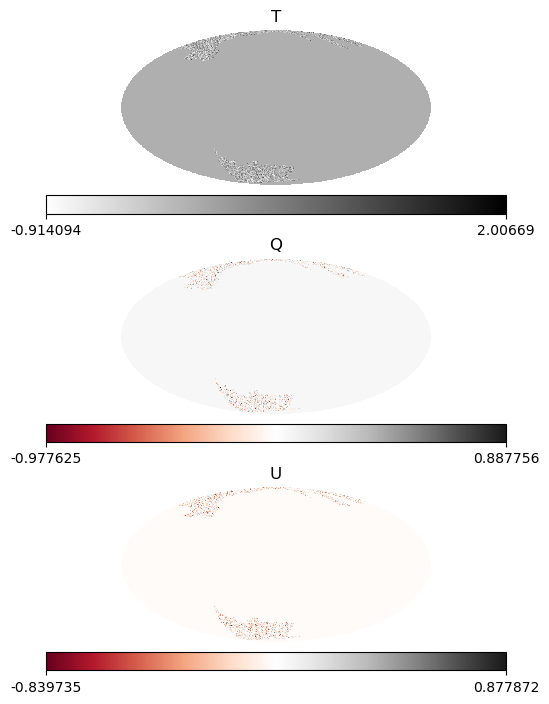

In [18]:
fig, ax = plt.subplots(3, figsize=(20, 7))
fig.tight_layout()
plt.sca(ax[0])
hp.mollview(eu_data_maps[('POS', 1)], cmap='binary', title='T', hold=True)
plt.sca(ax[1])
hp.mollview(eu_data_maps[('SHE', 1)][0], cmap='RdGy', title='Q', hold=True)
plt.sca(ax[2])
hp.mollview(eu_data_maps[('SHE', 1)][1], cmap='RdGy', title='U', hold=True)
plt.show()

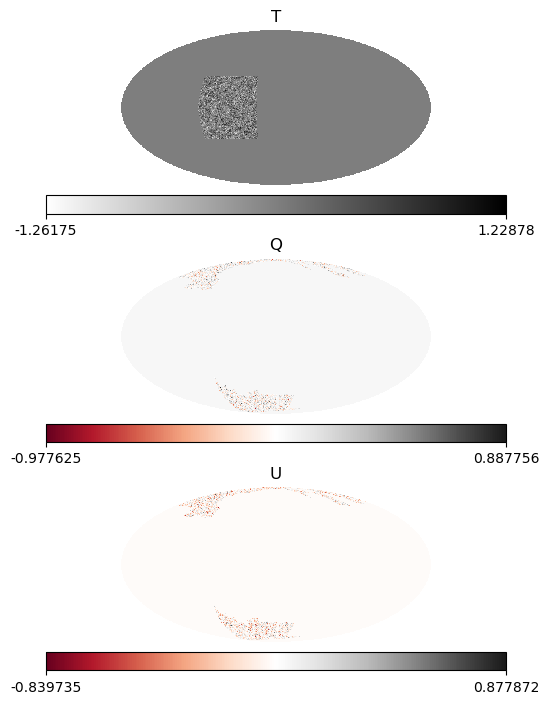

In [19]:
fig, ax = plt.subplots(3, figsize=(20, 7))
fig.tight_layout()
plt.sca(ax[0])
hp.mollview(data_map[('POS', 1)], cmap='binary', title='T', hold=True)
plt.sca(ax[1])
hp.mollview(data_map[('SHE', 1)][0], cmap='RdGy', title='Q', hold=True)
plt.sca(ax[2])
hp.mollview(data_map[('SHE', 1)][1], cmap='RdGy', title='U', hold=True)
plt.show()

### Binning

In [20]:
#bin_edges = np.logspace(np.log10(10), np.log10(lmax+1), bin_num+1).astype(int)
bin_edges = np.linspace(10, lmax+1, bin_num+1).astype(int)
B = np.diag(np.ones(lmax+1))
B = iolaus.bin2pt(B, bin_edges, 'B')
B = B['B']

n, m = B.shape
B2 = np.zeros((n, 2*lmax+1))
B2[:, :lmax+1] = B

In [21]:
# Binned ls
q = B @ l 

### Mixing Matrix

In [22]:
mapper = heracles.healpy.HealpixMapper(nside, lmax)
fields_data = iolaus.make_fields(mapper, mode='data')
mms = mixing_matrices(fields_data, mask_cls,
    l3max=2*lmax+lmax, l2max=2*lmax, l1max=lmax)

In [28]:
for key in list(mms.keys()):
    print(key, mms[key].shape)

('POS', 'POS', 1, 1) (1001, 2001)
('POS', 'SHE', 1, 1) (1001, 2001)
('SHE', 'SHE', 1, 1) (3, 1001, 2001)


### Plotting

In [24]:
compsep_theory_cls = iolaus.compsep_cls(theory_cls)
compsep_data_cls = iolaus.compsep_cls(data_cls)

In [25]:
fields_a = np.unique([i[0] for i in mms.keys()])
fields_b = np.unique([i[1] for i in mms.keys()])
print(fields_a)
print(list(mms.keys()))

['POS' 'SHE']
[('POS', 'POS', 1, 1), ('POS', 'SHE', 1, 1), ('SHE', 'SHE', 1, 1)]


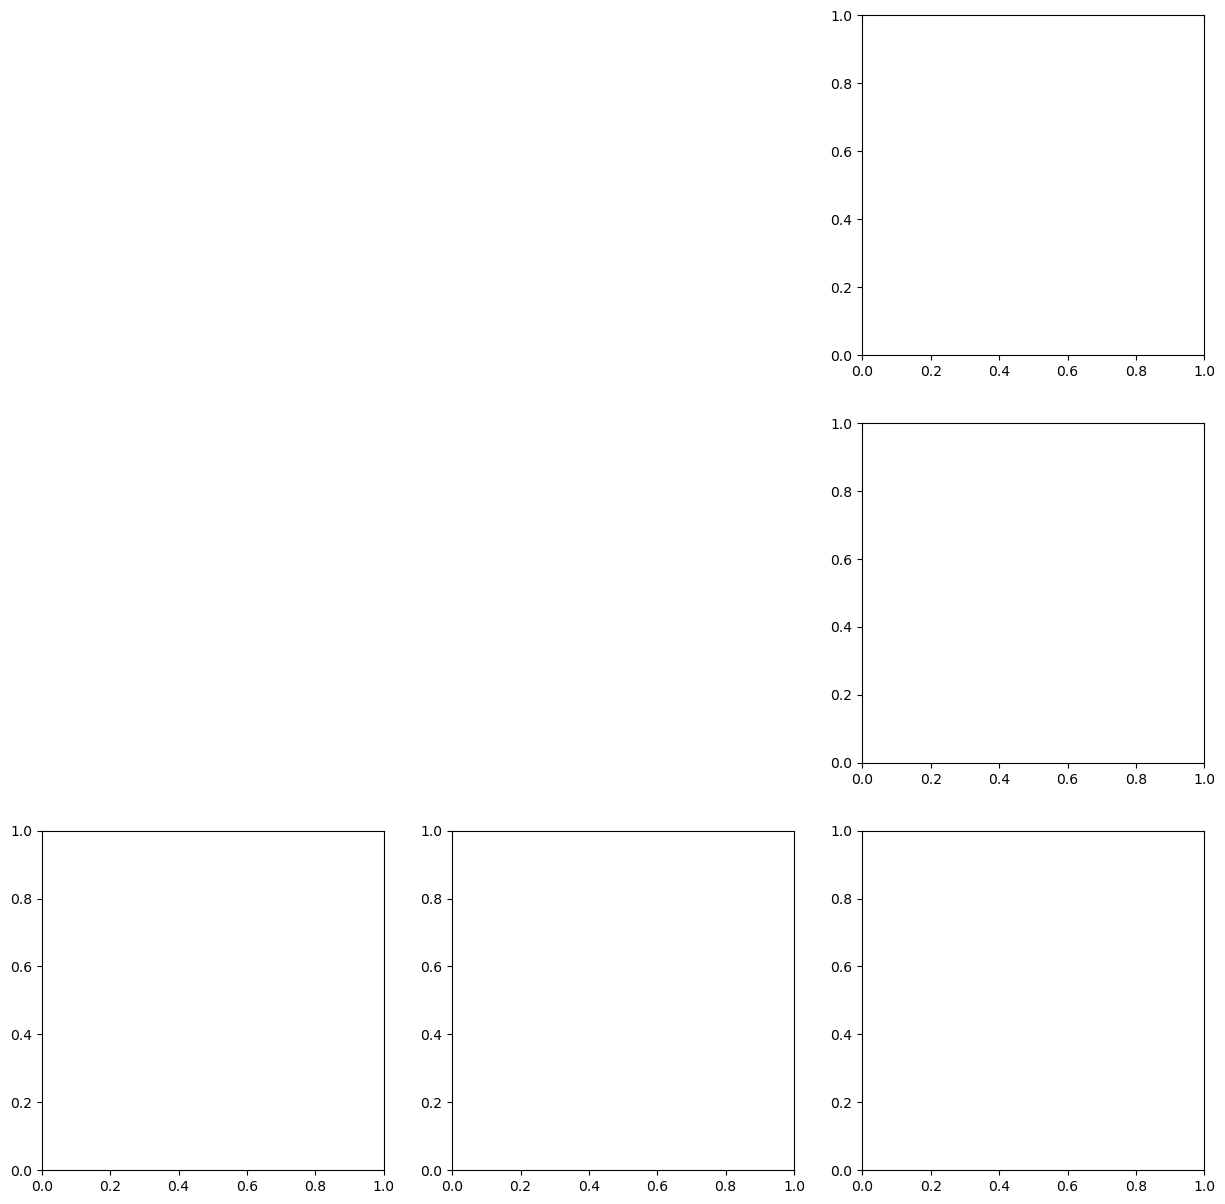

In [26]:
figure, axis = plt.subplots(3, 3, figsize=(5*3, 5*3))
for i, s1 in enumerate(fields_a):
    for j, s2 in enumerate(fields_b):
        proposed_key = (s1, s2, 0, 0)
        if proposed_key in list(mms.keys()):
            print(proposed_key) 
            t = theory_cls[proposed_key]
            d = data_cls[proposed_key]

            axis[i, j].plot(l,  d, label="Data Cls")
            axis[i, j].plot(l2, t, label="Theory Cls")
            axis[i, j].plot(q,  B @ d, "bo-", label="Binned Data Cls")
            axis[i, j].set_xscale('log')
            axis[i, j].set_yscale('log')
            axis[i, j].set_title(f"{s1}x{s2}")
            axis[i, j].set_xlabel(r"$\ell$")
            axis[i, j].set_ylabel(r"$C_\ell$")
            axis[i, j].grid()
            axis[i, j].set_xlim(2, 2*lmax)
            axis[i, j].legend()
        else:
            axis[i, j].axis('off')
plt.show()

## Forward Model 

In Fourier space, we can relate an observed angular power spectrum $\tilde{C}_\ell$ to a theoretical full-sky angular power spectrum $C_\ell$ through the mixing matrix $M$, a matrix that contains the effect of the mask:
$$ \tilde{C}_\ell = M C_\ell $$

We find better results by considering a non-square square matrix such that the theory $C_\ell$'s are evaluated up to $2\ell_{max}$, where $\ell_{max}$ is the maximum multipole considered for the observed $\tilde{C}_\ell$.

We can modify the previous fudamental relation to express all Fourier space methods by considering a general matrix, A, such that:
$$ A \tilde{C}_\ell = A M C_\ell $$

Becuase we are often interested in the binned angular power spectrum, in the forward method $A = B$, where $B$ is the binning matrix.

To account for the E-B mixing, we compute the parial sky $C_\ell$  as:
$$ \tilde{C}_\ell^{EE} = B(M^{EE} C_\ell^{BB} + M^{BB} C_\ell^{EE}) \\
   \tilde{C}_\ell^{BB} = B(M^{EE} C_\ell^{EE} + M^{BB} C_\ell^{BB}) 
$$

Note that in our case $C_\ell^{BB} = 0$ by definition.

In [27]:
from heracles.core import TocDict

forward_cls = {}
forward_cls[('G_B', 'G_B', 0, 0)] = mms[('G_E', 'G_E', 0, 0)] @ theory_cls[('G_B', 'G_B', 0, 0)] + mms[('G_B', 'G_B', 0, 0)] @ theory_cls[('G_E', 'G_E', 0, 0)]
forward_cls[('G_E', 'G_E', 0, 0)] = mms[('G_E', 'G_E', 0, 0)] @ theory_cls[('G_E', 'G_E', 0, 0)] + mms[('G_B', 'G_B', 0, 0)] @ theory_cls[('G_B', 'G_B', 0, 0)]
forward_cls[('P', 'P', 0, 0)] = mms[('P', 'P', 0, 0)] @ theory_cls[('P', 'P', 0, 0)]

KeyError: ('G_E', 'G_E', 0, 0)

In [ ]:
figure, axis = plt.subplots(1, 3, figsize=(5*3, 5))
for i, s1 in enumerate(fields_a):
    proposed_key = (s1, s1, 0, 0)
    print(proposed_key) 
    t = forward_cls[proposed_key]
    d = data_cls[proposed_key]

    axis[i].plot(q, B @ t, 'g-', label="Forward Theory")
    axis[i].plot(q, B @ d, 'bo--', alpha=0.6, label="Data")
    axis[i].set_xscale('log')
    axis[i].set_yscale('log')
    axis[i].set_title(f"{s1}x{s1}")
    axis[i].set_xlabel(r"$\ell$")
    if i == 0:
        axis[i].set_ylabel(r"$\tilde{C}_\ell$")
    axis[i].grid()
    axis[i].legend()
plt.show()

## Master Model

Similarly, the master method is equivalent to considering $A = (B M B^T)^{-1} B$.
Since the the initial steps of computing the master method $C_\ell$'s are the same as the forward method we reuse the previously computed $C_\ell$'s. However, we still need to apply the inverse binning matrix to get the final $C_\ell$'s.
Because we originally considered a non-square mixing matrix, we first crop the mixing matrix to the size of the data $C_\ell$'s we then bin. This operation is done in one single operation by applying the matrix $B_2$. 

Since the mixing of the E and B modes is already accounted in the first step when multiplying by the mixing matrix, we do not need to consider the mixing when inverting the binned mixing matrix.

In [ ]:
# bin mixing matrix
mms_qq = {}
for keys in list(mms.keys()):
    mms_qq[keys] = B @ mms[keys] @ B2.T

In [ ]:
master_method = "naive_inverse"
if master_method == "full_inverse":
    master_data_cls = {}
    m_qq_PP = mms_qq[('P', 'P', 0, 0)]
    inv_m_qq_PP = np.linalg.inv(m_qq_PP)
    master_data_cls[('P', 'P', 0, 0)] = inv_m_qq_PP @ (B @ data_cls[('P', 'P', 0, 0)])

    m_qq_EE = np.hstack([mms_qq[('G_E', 'G_E', 0, 0)], mms_qq[('G_E', 'G_B', 0, 0)]])
    m_qq_BB = np.hstack([mms_qq[('G_E', 'G_B', 0, 0)], mms_qq[('G_B', 'G_B', 0, 0)]])
    m_qq_EE_BB = np.vstack([m_qq_EE, m_qq_BB])
    inv_m_qq_EE_BB = np.linalg.pinv(m_qq_EE_BB)

    cq_EE_BB = np.hstack([B @ data_cls[('G_E', 'G_E', 0, 0)], B @ data_cls[('G_B', 'G_B', 0, 0)]])
    cq_EE_BB = inv_m_qq_EE_BB @ cq_EE_BB
    master_data_cls[('G_E', 'G_E', 0, 0)] = cq_EE_BB[bin_num:]
    master_data_cls[('G_B', 'G_B', 0, 0)] = cq_EE_BB[:bin_num]

    master_theory_cls = {}
    master_theory_cls[('P', 'P', 0, 0)] = inv_m_qq_PP @ (B @ forward_cls[('P', 'P', 0, 0)])
    cq_EE_BB = np.hstack([B @ forward_cls[('G_E', 'G_E', 0, 0)], B @ forward_cls[('G_B', 'G_B', 0, 0)]])
    cq_EE_BB = inv_m_qq_EE_BB @ cq_EE_BB
    master_theory_cls[('G_E', 'G_E', 0, 0)] = cq_EE_BB[bin_num:]
    master_theory_cls[('G_B', 'G_B', 0, 0)] = cq_EE_BB[:bin_num]

if master_method == "naive_inverse":
    master_data_cls = {}
    for key in list(forward_cls.keys()):
        m_qq = mms_qq[key]
        inv_m_qq = np.linalg.inv(m_qq)
        master_data_cls[key] = inv_m_qq @ (B @ data_cls[key])

    master_theory_cls = {}
    for key in list(forward_cls.keys()):
        m_qq = mms_qq[key]
        inv_m_qq = np.linalg.inv(m_qq)
        master_theory_cls[key] = inv_m_qq @ (B @ forward_cls[key])

In [ ]:
figure, axis = plt.subplots(1, 3, figsize=(5*3, 5))
for i, s1 in enumerate(fields_a):
    proposed_key = (s1, s1, 0, 0)
    print(proposed_key) 
    t = master_theory_cls[proposed_key]
    d = master_data_cls[proposed_key]

    axis[i].plot(q, t, 'g-', label="Master Theory")
    axis[i].plot(q, d, 'bo--', alpha=0.6, label="Master Data")
    axis[i].set_xscale('log')
    axis[i].set_yscale('log')
    axis[i].set_title(f"{s1}x{s1}")
    axis[i].set_xlabel(r"$\ell$")
    if i == 0:
        axis[i].set_ylabel(r"$\tilde{C}_\ell$")
    axis[i].grid()
    axis[i].legend()
plt.show()

## Direct Inversion

The direct inversion method is equivalent to considering $A = B M^{-1}$.

To account for the E-B mixing, we compute the full sky $C_\ell^{E/B}$  as:
$$  \begin{bmatrix} 
 \langle C_l^{E\!E'} \rangle \\ \langle C_l^{B\!B'} \rangle  \end{bmatrix}
 =
\begin{bmatrix}
   M^{E\!E E'\!E'} & M^{B\!B E'\!E'} \\
   M^{E\!E B'\!B'} & M^{B\!B B'\!B'} 
\end{bmatrix}^{-1}
\begin{bmatrix} 
    \langle \tilde{C}_l^{E\!E'} \rangle \\ \langle \tilde{C}_l^{B\!B'} \rangle 
\end{bmatrix}
$$

In [ ]:
inversion_cls = {}
cl_EE_BB = np.append(data_cls[('G_E', 'G_E', 0, 0)], data_cls[('G_B', 'G_B', 0, 0)])
M_EE = np.hstack([mms[('G_E', 'G_E', 0, 0)], mms[('G_E', 'G_B', 0, 0)]])
M_BB = np.hstack([mms[('G_E', 'G_B', 0, 0)], mms[('G_B', 'G_B', 0, 0)]])
M_EE_BB = np.vstack([M_EE, M_BB])
inv_M_EE_BB = np.linalg.pinv(M_EE_BB)
cl_EE_BB = inv_M_EE_BB @ cl_EE_BB
inversion_cls[('G_E', 'G_E', 0, 0)] = cl_EE_BB[2*lmax+1:]
inversion_cls[('G_B', 'G_B', 0, 0)] = cl_EE_BB[:2*lmax+1]
inversion_cls[('P', 'P', 0, 0)]     = np.linalg.pinv(mms[('P', 'P', 0, 0)]) @ data_cls[('P', 'P', 0, 0)]

In [ ]:
figure, axis = plt.subplots(1, 3, figsize=(5*3, 5))
for i, s1 in enumerate(fields_a):
    proposed_key = (s1, s1, 0, 0)
    print(proposed_key) 
    t = theory_cls[proposed_key]
    d = inversion_cls[proposed_key]

    axis[i].plot(q, B2 @ t, 'g-', label="Theory")
    axis[i].plot(q, B2 @ d, 'bo--', alpha=0.6, label="Inversion Data")
    axis[i].set_xscale('log')
    axis[i].set_yscale('log')
    axis[i].set_title(f"{s1}x{s1}")
    axis[i].set_xlabel(r"$\ell$")
    if i == 0:
        axis[i].set_ylabel(r"$C_\ell$")
    axis[i].grid()
    axis[i].legend()
plt.show()

## Polspice

In the Polspice method we account for the effect of the mask in real space. 
Let's start laying down some definitions. Given a complex field:
$$ \gamma(n) = (Q \pm i U)(n) = \sum_{l m} (E_{l m} \mp i B_{l m}) _{\mp 2} Y_{l m}(n)  $$
we can define the correlators:
$$ \xi_{+} = \langle \gamma^* \gamma\rangle  \hspace{6pt}\rm{and}\hspace{6pt} \xi_{-} = \langle \gamma \gamma \rangle $$
Then the associated parital sky correlatiors are given by:
$$ \xi_{\pm}(\theta) = \frac{\tilde{\xi}_{\pm}(\theta)}{\xi^{ww'}(\theta)} $$
which we can also express in terms of linear combinations of the measured $E$ and $B$ angular power spectra:
$$  \tilde{\xi}_{\pm}(\theta) = \sum_l \frac{2l+1}{4\pi}(\tilde{C}^{EE}_l \pm  \tilde{C}^{BB}_l) d^l_{2 \pm 2}(\theta) $$

The PolSpice method undoes the $E-B$ coupling by defining a correlator akin to $\xi_{+}(\theta)$ but with the Wigner matrix of a spin -2 field:
$$
\xi_{\rm dec}(\theta) = \frac{\tilde{\xi}_{\rm dec}(\theta)}{\xi^{ww'}(\theta)} = \nonumber \\ 
= \frac{1}{\xi^{ww'}(\theta)} \sum_l \frac{2l+1}{4\pi}(\tilde{C}^{EE}_l +  \tilde{C}^{BB}_l) d^l_{2 - 2}(\theta)
$$

Then one can construct a estimator for the full sky angular correlation functions by combining the correlation function and inverting the SWSH transform:
$$
C^{EE}_l = 2\pi \int \frac{1}{2}[\xi_{\rm dec}(\theta) + \xi_{-}(\theta)] d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta} $$
$$
C^{BB}_l = 2\pi \int \frac{1}{2}[\xi_{\rm dec}(\theta) - \xi_{-}(\theta)] d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta} $$

In [ ]:
import transformcl
import wigner

In [ ]:
def cl2corr_mat(theta, lmax=None, spin1=0, spin2=0):
    if lmax is None:
        lmax = len(theta) - 1
    m = np.empty((len(theta), lmax + 1))
    f = (2 * np.arange(lmax + 1) + 1) / (4 * np.pi)
    for i, t in enumerate(theta):
        m[i] = f * wigner.wigner_dl(0, lmax, spin1, spin2, t)
    return m

def corr2cl_solve(mat, corr, spin1=0, spin2=0):
    k = max(abs(spin1), abs(spin2))
    cut_mat = mat[:, k:]
    return np.pad(np.linalg.solve(cut_mat, corr), (k, 0))

def corr2cl_lstsq(mat, corr):
    return np.linalg.lstsq(mat, corr, None)[0]

def apodize(x, x0=-2, k=50):
    return (1+np.exp(-k*(x-x0)))

In [ ]:
Fm = transformcl.cltocorr(mask_cls[('V', 'V', 0, 0)][:1001])
Fm_full = transformcl.cltocorr(mask_cls[('V', 'V', 0, 0)])
Fm_apo = (Fm* apodize(np.log10(np.abs(Fm))))
Fm_apo_full = (Fm_full * apodize(np.log10(np.abs(Fm_full))))

In [ ]:
cl_PP =  transformcl.corrtocl(transformcl.cltocorr(data_cls[('P', 'P', 0, 0)])/(Fm_apo))

th = transformcl.theta(2*lmax+1)
mat_p = cl2corr_mat(th, lmax, 2, 2)
mat_m = cl2corr_mat(th, lmax, 2, -2)
cl_EE_p_BB = data_cls[('G_E', 'G_E', 0, 0)] + data_cls[('G_B', 'G_B', 0, 0)]
cl_EE_m_BB = data_cls[('G_E', 'G_E', 0, 0)] - data_cls[('G_B', 'G_B', 0, 0)]

xi_m = mat_m @ cl_EE_m_BB
xi_p = mat_p @ cl_EE_p_BB
xi   = mat_m @ cl_EE_p_BB
pols_Cl_BB = corr2cl_lstsq(mat_m, 0.5*(xi-xi_m)/Fm_apo_full)
pols_Cl_EE = corr2cl_lstsq(mat_m, 0.5*(xi+xi_m)/Fm_apo_full)

polspice_cls = {}
polspice_cls[('G_B', 'G_B', 0, 0)] = pols_Cl_BB
polspice_cls[('G_E', 'G_E', 0, 0)] = pols_Cl_EE
polspice_cls[('P', 'P', 0, 0)]     = cl_PP

However, this just one choice of an estimator for the decoupled angular power spectra. In order to understand this estimators better it is useful to inspect the $C^{BB}_l$:
$$
C^{BB}_l = 2\pi \int \frac{1}{2\xi^{ww'}(\theta)}[\left(\sum_l \frac{2l+1}{4\pi}(\tilde{C}^{EE}_l +  \tilde{C}^{BB}_l) d^l_{2 - 2}(\theta)\right) \nonumber \\ - \left(\sum_l \frac{2l+1}{4\pi}(\tilde{C}^{EE}_l - \tilde{C}^{BB}_l) d^l_{2 -2}(\theta)\right)] d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta}  =  \, \nonumber \\
= 2\pi \int \frac{1}{\xi^{ww'}(\theta)} \left(\sum_l \frac{2l+1}{4\pi} \tilde{C}^{BB}_l d^l_{2 - 2}(\theta)\right) d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta} = \nonumber \\ 
= 2\pi \int \frac{\xi^{BB}(\theta)}{\tilde{\xi}^{ww'}(\theta)}  d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta} \, . 
$$

Thus, we can see that no E-modes are subtracted from $C^{BB}_l$ this approach. We can perform a similar expansion for the E-mode expression. First allows us to write $\tilde{\xi}(\theta)$ in terms of $\tilde{\xi}_{-}(\theta)$. This can be done by adding and subtracting $\tilde{C}^{BB}_l$: 
$$
\tilde{\xi}_{\rm dec}(\theta) = \tilde{\xi}_{-}(\theta) + 2 \sum_l \frac{2l+1}{4\pi} \tilde{C}^{BB}_l d^l_{2-2}(\theta) 
$$
Now, plugging these two equations into each other:
$$
C^{EE}_l = \nonumber \\  
2\pi \int \frac{1}{\xi^{ww'}(\theta)}[\tilde{\xi}_{-}(\theta) + \left(\sum_l \frac{2l+1}{4\pi}\tilde{C}^{BB}_l d^l_{2 -2}(\theta)\right)] d^{l}_{2-2}(\theta) {\rm d}\!\cos{\theta} \,  \nonumber \\
= 2\pi \int \xi_{-}(\theta) d^{l}_{2-2} {\rm d}\!\cos{\theta} + C_l^{BB}
$$
which shows the expected mixing.

Alternatively, we could construct a series of estimators which exhibit mixing for both $C^{EE}_l$ and $C^{BB}_l$. In order to do so let us define the angular power spectra:
$$
C_l^{\pm} = C_l^{EE} \pm C_l^{BB} = \nonumber \\
= 2 \pi \int \frac{1}{\xi^{ww'}(\theta)} \left( \sum_l \frac{2l+1}{4\pi} (\tilde{C}_l^E \pm \tilde{C}_l^B) d^l{2\pm2}\right) d^l_{2\pm2} {\rm d}\cos{\theta} 
$$
Then the respective estimators for the uncoupled E and B fields can be obtained by considering:
$$
C_l^{EE} = \frac{1}{2}(C_l^{+} + C_l^{-}) \hspace{6pt}\rm{and}\hspace{6pt} C_l^{BB} = \frac{1}{2}(C_l^{+} - C_l^{-})
$$

In [ ]:
cl_p = corr2cl_lstsq(mat_p, (1/Fm_apo_full) * (mat_p @ cl_EE_p_BB))
cl_m = corr2cl_lstsq(mat_m, (1/Fm_apo_full) * (mat_m @ cl_EE_m_BB))
npols_Cl_EE = 0.5*(cl_p + cl_m)
npols_Cl_BB = 0.5*(cl_p - cl_m)

naive_polspice_cls = {}
naive_polspice_cls[('G_B', 'G_B', 0, 0)] = npols_Cl_BB
naive_polspice_cls[('G_E', 'G_E', 0, 0)] = npols_Cl_EE
naive_polspice_cls[('P', 'P', 0, 0)]     = cl_PP

In [ ]:
figure, axis = plt.subplots(1, 3, figsize=(5*3, 5))
for i, s1 in enumerate(fields_a):
    proposed_key = (s1, s1, 0, 0)
    print(proposed_key) 
    t = theory_cls[proposed_key]
    d_p = polspice_cls[proposed_key]
    d_np = naive_polspice_cls[proposed_key]

    axis[i].plot(q, B @ d_p, 'bo-', alpha=0.3, label="PolSpice")
    axis[i].plot(q, B @ d_np, 'ro-', alpha=0.3, label="Naive PolSpice")
    axis[i].plot(q, B2 @ t, 'g-', label="theory")
    axis[i].set_xscale('log')
    axis[i].set_yscale('log')
    axis[i].set_title(f"{s1}x{s1}")
    axis[i].set_xlabel(r"$\ell$")
    if i == 0:
        axis[i].set_ylabel(r"$C_\ell$")
    axis[i].grid()
    axis[i].legend()
plt.show()